In [1]:
%pip install torchview

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision import models, Module
from torchsummary import summary
from torchview import draw_graph

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import cv2

In [3]:
g_train = {"fake": [], "real": []}
g_test  = {"fake": [], "real": []}

base_dirs = [
    "/kaggle/input/deepfake-image-detection/train-20250112T065955Z-001",
    "/kaggle/input/deepfake-image-detection/test-20250112T065939Z-001"
]

labels = ["fake", "real"]

for base_dir in base_dirs:
    for label in labels:
        img_dir = os.path.join(base_dir, "train" if "train" in base_dir else "test", label)
        files = [os.path.join(img_dir, x) for x in os.listdir(img_dir)]
        if "train" in base_dir:
            g_train[label] += files
        else:
            g_test[label] += files
print("Done!")

Done!


In [4]:
all_images = []
all_labels = []
for label in labels:
    all_images += g_train[label] + g_test[label]
    all_labels += [label]*len(g_train[label]) + [label]*len(g_test[label])

print("Done!")

Done!


In [5]:
data = pd.DataFrame({"images": all_images, "labels":all_labels})
display(data)

images labels
0    /kaggle/input/deepfake-image-detection/train-2...   fake
1    /kaggle/input/deepfake-image-detection/train-2...   fake
2    /kaggle/input/deepfake-image-detection/train-2...   fake
3    /kaggle/input/deepfake-image-detection/train-2...   fake
4    /kaggle/input/deepfake-image-detection/train-2...   fake
..                                                 ...    ...
973  /kaggle/input/deepfake-image-detection/test-20...   real
974  /kaggle/input/deepfake-image-detection/test-20...   real
975  /kaggle/input/deepfake-image-detection/test-20...   real
976  /kaggle/input/deepfake-image-detection/test-20...   real
977  /kaggle/input/deepfake-image-detection/test-20...   real

[978 rows x 2 columns]

In [6]:
data = data.sample(frac=1, random_state=42)  
data.reset_index(drop=True, inplace=True) 

display(data)

images labels
0    /kaggle/input/deepfake-image-detection/test-20...   fake
1    /kaggle/input/deepfake-image-detection/train-2...   real
2    /kaggle/input/deepfake-image-detection/test-20...   fake
3    /kaggle/input/deepfake-image-detection/test-20...   real
4    /kaggle/input/deepfake-image-detection/train-2...   fake
..                                                 ...    ...
973  /kaggle/input/deepfake-image-detection/train-2...   fake
974  /kaggle/input/deepfake-image-detection/test-20...   fake
975  /kaggle/input/deepfake-image-detection/train-2...   real
976  /kaggle/input/deepfake-image-detection/test-20...   fake
977  /kaggle/input/deepfake-image-detection/train-2...   fake

[978 rows x 2 columns]

In [7]:
label_map = {'fake': 0, 'real':1}
data['labels'] = data['labels'].map(label_map)
display(data)

images  labels
0    /kaggle/input/deepfake-image-detection/test-20...       0
1    /kaggle/input/deepfake-image-detection/train-2...       1
2    /kaggle/input/deepfake-image-detection/test-20...       0
3    /kaggle/input/deepfake-image-detection/test-20...       1
4    /kaggle/input/deepfake-image-detection/train-2...       0
..                                                 ...     ...
973  /kaggle/input/deepfake-image-detection/train-2...       0
974  /kaggle/input/deepfake-image-detection/test-20...       0
975  /kaggle/input/deepfake-image-detection/train-2...       1
976  /kaggle/input/deepfake-image-detection/test-20...       0
977  /kaggle/input/deepfake-image-detection/train-2...       0

[978 rows x 2 columns]

In [8]:
Images = []
Labels = []
max_height = float('-inf')
min_height = float('inf')
max_weidth = float('-inf')
min_weidth = float('inf')
for i in range(len(data)):
    image_path = data['images'][i]
    label = data['labels'][i]
    try:
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if img is None:
           raise FileNotFoundError("Image not found or unable to read the file.")
        Images.append(img)
        Labels.append(label)
        max_height = max(max_height, img.shape[0])
        min_height = min(min_height, img.shape[0])
        max_weidth = max(max_weidth, img.shape[1])
        min_weidth  = min(min_weidth, img.shape[1])
    except Exception as e:
        print("An unexpected error occurred:", e)

print(f"Max Height: {max_height}")
print(f"Min Height: {min_height}")

print(f"Max Weidth: {max_weidth}")
print(f"Min Weidth: {min_weidth}")

Max Height: 7091
Min Height: 135
Max Weidth: 8495
Min Weidth: 183


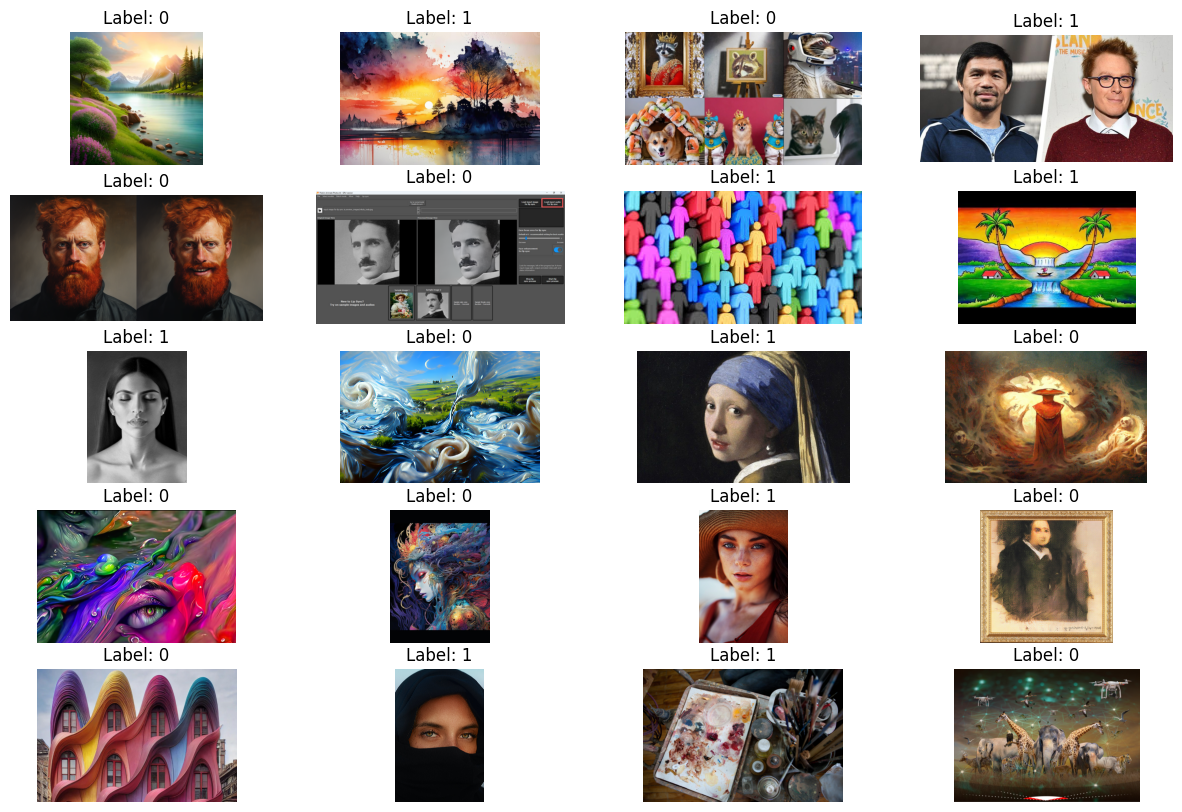

In [9]:
num_imgs = 20
ncols = 4
nrows = (num_imgs + ncols - 1) // ncols
plt.figure(figsize=(15, 10))
for i, img in enumerate(Images[:num_imgs]):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(img)
    plt.title(f"Label: {Labels[i]}")
    plt.axis('off')
plt.show()

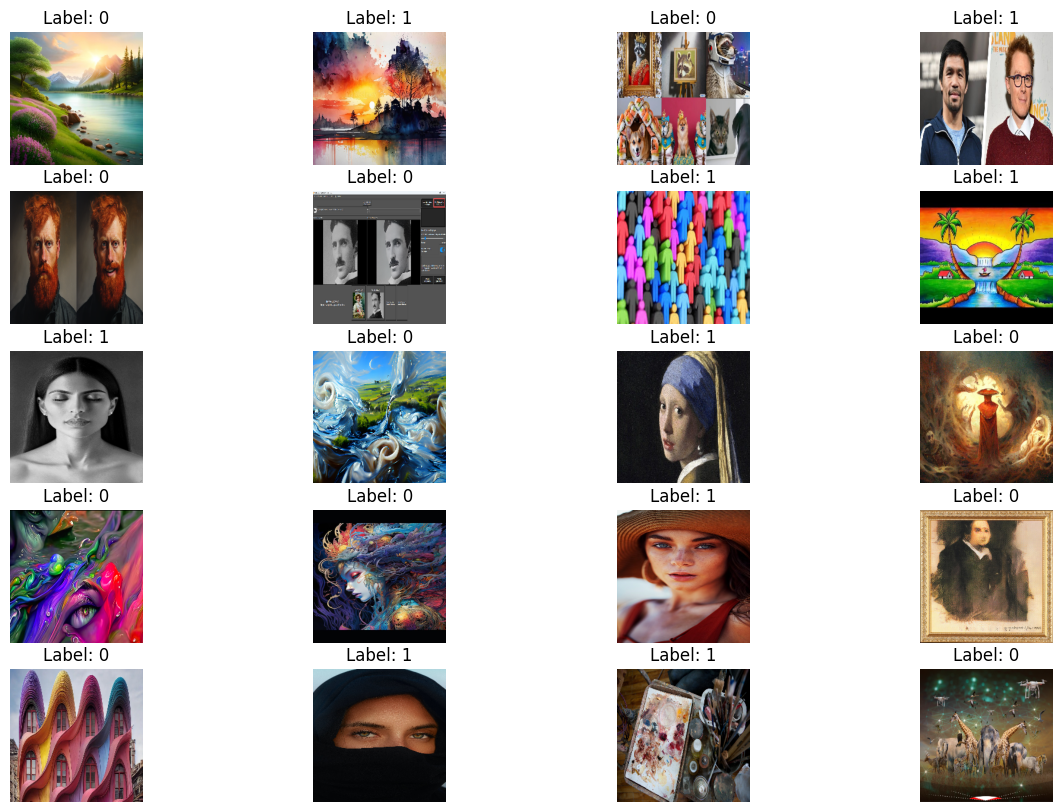

In [10]:
target_size = (224,224)
Images_resize = [cv2.resize(img, target_size) for img in Images]

num_imgs = 20
ncols = 4
nrows = (num_imgs + ncols - 1) // ncols
plt.figure(figsize=(15, 10))
for i, img in enumerate(Images_resize[:num_imgs]):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(img)
    plt.title(f"Label: {Labels[i]}")
    plt.axis('off')
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(Images_resize, Labels, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
print("Training data shape:", len(X_train))
print("Validation data shape:", len(X_val))
print("Testing data shape:", len(X_test))

Training data shape: 792
Validation data shape: 88
Testing data shape: 98


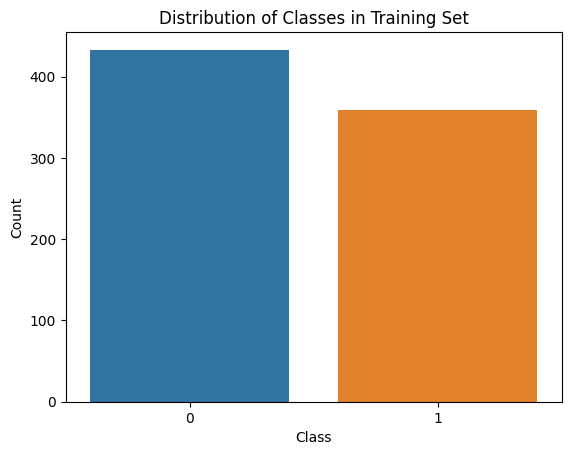

In [12]:
sns.countplot(x=np.array(y_train))
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Distribution of Classes in Training Set")
plt.show()

In [13]:
transform = transforms.Compose([
    transforms.ToPILImage(), 
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),  
])

class CustomImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        """
        images: List of NumPy arrays (H, W, C) 
        labels: List or NumPy array of shape (N,)
        transform: Augmentation transformations
        """
        self.images = np.array(images)  
        self.labels = torch.tensor(np.array(labels), dtype=torch.long)
        self.transform = transform  

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label

train_dataset = CustomImageDataset(X_train, y_train, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = CustomImageDataset(X_val, y_val, transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)

In [14]:
images, labels = next(iter(train_dataloader))
print(images.shape) 
print(labels)

torch.Size([64, 3, 224, 224])
tensor([1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0,
        1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0])


In [15]:
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
for param in model.parameters():
    param.requires_grad = False 

num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 1024),  # First fully connected layer
    nn.BatchNorm1d(1024),       # Batch Normalization
    nn.LeakyReLU(),             # Activation function
    nn.Dropout(0.5),            # Dropout for regularization
    
    nn.Linear(1024, 512),       # Second fully connected layer
    nn.BatchNorm1d(512),        # Batch Normalization
    nn.LeakyReLU(),             # Activation function
    nn.Dropout(0.5),            # Dropout for regularization
    
    nn.Linear(512, 1),          # Final fully connected layer
    nn.Sigmoid()                # Sigmoid activation for binary classification
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 168MB/s] 


In [16]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

def binary_accuracy(preds, labels):
    preds = (preds >= 0.5).float()  
    return (preds == labels).sum().item() / labels.size(0)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

def train(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=10, save_path="best_model.pth"):
    best_val_loss = float('inf') 
    for epoch in range(epochs):
        model.train()
        train_loss, train_acc = 0.0, 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)  # Ensure labels are float

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_acc += binary_accuracy(outputs, labels)

        model.eval()
        val_loss, val_acc = 0.0, 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device).float().unsqueeze(1)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                val_acc += binary_accuracy(outputs, labels)
        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            print(f"Saving the Model with loss{best_val_loss}")
            torch.save(model.state_dict(), save_path)
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc/len(train_loader):.4f} | "
              f"Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc/len(val_loader):.4f}|",
              f"LR:{current_lr:.6f} ")


In [17]:
train(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, epochs=100, save_path="best_resnet50.pth")

Saving the Model with loss1.342215120792389
Epoch 1/100 | Train Loss: 0.6736, Train Acc: 0.5801 | Val Loss: 0.6711, Val Acc: 0.6979| LR:0.000100 
Saving the Model with loss1.2212321758270264
Epoch 2/100 | Train Loss: 0.5703, Train Acc: 0.7232 | Val Loss: 0.6106, Val Acc: 0.7500| LR:0.000100 
Saving the Model with loss1.0803151726722717
Epoch 3/100 | Train Loss: 0.4990, Train Acc: 0.7833 | Val Loss: 0.5402, Val Acc: 0.7734| LR:0.000100 
Saving the Model with loss0.9798375368118286
Epoch 4/100 | Train Loss: 0.4527, Train Acc: 0.8021 | Val Loss: 0.4899, Val Acc: 0.7812| LR:0.000100 
Epoch 5/100 | Train Loss: 0.4056, Train Acc: 0.8273 | Val Loss: 0.5011, Val Acc: 0.7526| LR:0.000100 
Saving the Model with loss0.8081409335136414
Epoch 6/100 | Train Loss: 0.3793, Train Acc: 0.8438 | Val Loss: 0.4041, Val Acc: 0.8281| LR:0.000100 
Epoch 7/100 | Train Loss: 0.3397, Train Acc: 0.8686 | Val Loss: 0.4625, Val Acc: 0.7370| LR:0.000100 
Epoch 8/100 | Train Loss: 0.3124, Train Acc: 0.8790 | Val Loss

In [18]:
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])
test_dataset = CustomImageDataset(X_test, y_test, transform=test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=len(X_test), shuffle=False)
model.eval()
val_acc = 0.0
with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)

        outputs = model(images)
        val_acc += binary_accuracy(outputs, labels)
print(f"Test Accuracy: {val_acc}")

Test Accuracy: 0.8469387755102041


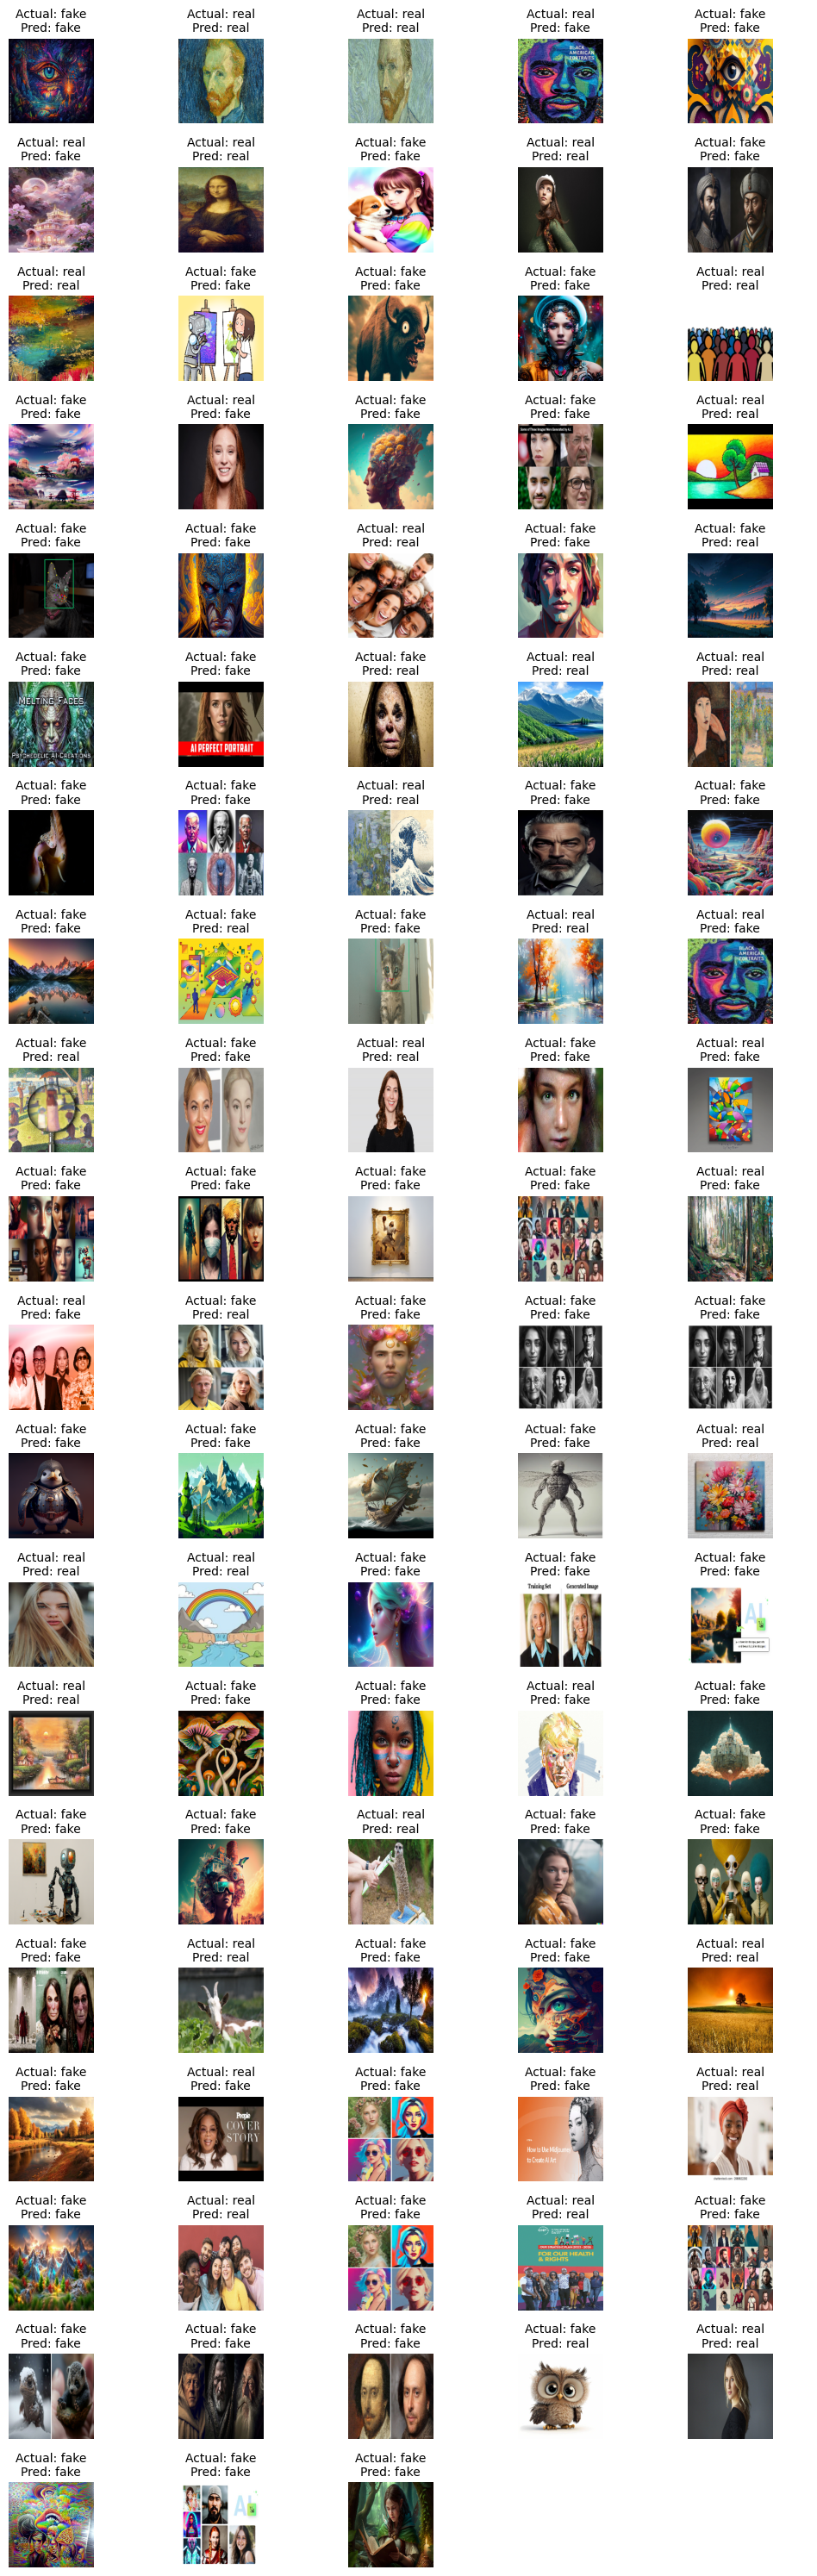

In [19]:
def plot_test_images(image_list, labels, preds, class_names, num_images=10):
    """
    image_list: List of test images (NumPy arrays in [H, W, C] format).
    labels: List or array of actual labels.
    preds: List or array of predicted labels.
    class_names: Dictionary or list mapping label indices to class names.
    num_images: Number of images to display.
    """
    num_images = min(num_images, len(image_list))  
    ncols = 5
    nrows = int(np.ceil(num_images / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 30))
    axes = axes.flatten()
    
    for i in range(num_images):
        img = image_list[i] 
        actual_label = class_names[labels[i]]
        predicted_label = class_names[1 if preds[i] >= 0.5 else 0]
        axes[i].imshow(img)
        axes[i].set_title(f"Actual: {actual_label}\nPred: {predicted_label}", fontsize=10)
        axes[i].axis("off")
    for i in range(num_images, len(axes)):  
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()
    
plot_test_images(image_list=X_test,labels=y_test, preds=outputs, class_names={0: "fake", 1: "real"}, num_images=len(X_test))

In [20]:
from IPython.display import FileLink
FileLink("best_resnet50.pth")

/kaggle/working/best_resnet50.pth